In [23]:
import json
import sys
import os
from groq import Groq
import difflib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from dotenv import load_dotenv
from nltk.corpus import stopwords
import re

# Ensure you have downloaded the NLTK stopwords
nltk.download('stopwords')

load_dotenv()
groq_api_key = os.environ.get("GROQ_API_KEY")
groq_client = Groq(api_key=groq_api_key)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jerryyang/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Filters I need:

- Filter out laundry chat
- Message must have a key='text' not None
- Message must not have photo, media_type, poll. (Width, height cannot be in the key)
- Keys i want: ['text' (Theres an inner dictionary sometimes),'from', 'date', ]


In [32]:
with open("../data/racist/result.json","r", encoding='utf-8') as fin:
    chat = json.load(fin)['messages']
    
months = {
    "01": "January",
    "02": "February",
    "03": "March",
    "04": "April",
    "05": "May",
    "06": "June",
    "07": "July",
    "08": "August",
    "09": "September",
    "10": "October",
    "11": "November",
    "12": "December"
}

def filter_chat(chat):
    before = len(chat)
    print(f"Initial length of chat: {before}\n")
    
    # Filtering out the laundry chat
    laundry_words = ["W2", "w2", "w1","W1","D2", "D1", "d2", "d1","Shifted", "shifted", "moved", "Moved", "dryer", "Washer", "washer", "washers", "dryers"]
    chat[:] = [msg for msg in chat if not any(word in msg['text'] for word in laundry_words)]
    chat[:] = [msg for msg in chat if msg['text'] and msg['text_entities']]    
    chat[:] = [msg for msg in chat if 'photo' not in msg or 'media_type' not in msg or 'poll' not in msg] 
    after = len(chat)
    print(f"After filtering, the length of chat: {after}\n")
    return chat

filtered_chat = filter_chat(chat)
def get_unique_names(chat):
    name_list = []
    for i in range(len(chat)):
        try:
            name = chat[i]['from']
            if chat[i]['from'] not in name_list:
                name_list.append(chat[i]['from'])
        except KeyError:
            try:
                name = chat[i]['actor']
                if chat[i]['actor'] not in name_list:
                    name_list.append(chat[i]['from'])
            except KeyError:
                print(chat[i])
                sys.exit()
    for i in range(len(name_list)):
        if name_list[i].endswith("CAPT"):
            name_list[i] = name_list[i][:-5]
        elif name_list[i].endswith("NUS"):
            name_list[i] = name_list[i][:-4]
        
    return name_list

# Function to filter - By name
def find_unique_name(name_list, input_name):
    # Normalize the names by converting them to lowercase
    normalized_names = [name.lower() for name in name_list]

    # Check if the input_name is unique in the normalized list
    if normalized_names.count(input_name.lower()) == 1:
        return f'Did you mean "{input_name}"?'
    
    # Find close matches to the input_name in the normalized list
    close_matches = difflib.get_close_matches(input_name.lower(), normalized_names, n=1, cutoff=0.6)
    
    if close_matches:
        # Find the original name that corresponds to the closest match
        original_name = [name for name in name_list if name.lower() in close_matches][0]
        answer = input(f"Did you mean {original_name}?, answer y/n")
        if answer.lower() == 'y':
            name = original_name
        elif answer.lower()  == 'n':
            name = "Please Choose another name"
        else:
            name = "None found"
    return name

def get_doing(input_name, chat):
    name_list = get_unique_names(chat)
    if input_name not in [name.lower() for name in name_list]:
        name = find_unique_name(name_list, input_name)
    else:
        name = input_name
    month = input("Which month do you want to look at? eg May = 05")

    def get_facts(name, chat, filtered_chat):
                
        def get_percentage():
            name_msgs = []
            for msg in filtered_chat:
                try:
                    if msg['from'] == name:
                        name_msgs.append(msg)
                        continue
                except KeyError:
                    if msg['actor'] ==  name:
                        name_msgs.append(msg)
                        continue
            percentage_sent = round(len(name_msgs)/ len(chat) * 100,2)
            return percentage_sent
        
        def get_wordcloud():
            name_msgs = []
            for msg in filtered_chat:
                try:
                    if msg['from'] == name and isinstance(msg['text'], str):
                        name_msgs.append(msg)
                        continue
                except KeyError:
                    if msg['actor'] == name and isinstance(msg['text'], str):
                        name_msgs.append(msg)
                        continue
            custom_stopwords = set(stopwords.words('english'))
            custom_stopwords.update(['u', 'im', 'think', 'go', 'dont', 'want', 'need', 'wait', 'ok', 'ah'])

            # Initialize an empty text corpus
            text_corpus = ""

            # Process each message in name_msgs
            for msg in name_msgs:
                # Remove non-alphabetic characters and convert to lowercase
                msg_text = re.sub(r'\W+', ' ', msg['text']).lower()
                # Split the text into words
                words = msg_text.split()
                # Remove stopwords
                filtered_words = [word for word in words if word not in custom_stopwords]
                # Join the words back into a string
                filtered_text = ' '.join(filtered_words)
                # Add the filtered text to the corpus
                text_corpus += filtered_text + " "
            
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')  # Turn off axis
            plt.show()
            
        name_percentage = get_percentage()
        print(f"{name} has sent {name_percentage}% of messages in the words that end with ist Chat since January")
        get_wordcloud()
        return

    get_facts(name, chat, filtered_chat)
    # Filter by name and time
    name_msgs = []
    for msg in chat:
            try:
                if msg['from'] == name and msg['date'][5:7]== month and isinstance(msg['text'], str):
                    name_msgs.append(msg)
                    continue
            except KeyError:
                if msg['actor'] ==  name and msg['date'][5:7]== month and isinstance(msg['text'], str):
                    name_msgs.append(msg)
                    continue
    print(f"From my observations, {name} sent {len(name_msgs)} messages in {months[month]}!\n")
    
    text_corpus = ""
    for msg in name_msgs:
        text_en = msg['text_entities']
        if len(text_en) > 1:
            for text in text_en:
                if text['type']=='plain':
                    text_to_add = text['text'] + "\n"
                    text_corpus.append(text_to_add)
        else:
            if text_en[0]['type']=='plain':
                    text_to_add = text_en[0]['text'] + "\n"
                    text_corpus += text_to_add

    def llama_chat(client, user_question):
        chat_completion = client.chat.completions.create(
            messages = [
                {
                    "role": "user",
                    "content": user_question
                }
            ],
            model = "llama3-8b-8192"
        )
        response = chat_completion.choices[0].message.content
        return response
    if len(name_msgs) > 0:
        template_month = '''
        Given the name, month, and series of text messages of a teenager in a month, \
        you are to summarise in bullet points what he/her has been doing in the month based on the text messages.
        Note that teenagers may sometimes use slang. Customise the outputs based on these slangs
        Ensure that the generated summaries are factually accurate, and avoid making up information. \
        If the text messages are empty, say that the 'person did not do anything in {{month}}'
        If the text messages are too short, simply output the text messages.
        
        Start it off with "Hi, my name is {{fill in name here}}, and this is what i did in {{month}}!:"
        Name:
        ''' + name  +\
        "Month: " + str(months[month]) + \
        '''
        \ntext messages:  
        ''' + text_corpus +\
        "Once again, ensure that the information provided is factually accurate. "
        
        answer = llama_chat(groq_client, template_month)
    else:
        answer = f"{name} did not do anything in {months[month]}. sad... phantom..."
    return answer

Initial length of chat: 12762

After filtering, the length of chat: 12332



Jarod Yoong has sent 24.86% of messages in the words that end with ist Chat since January


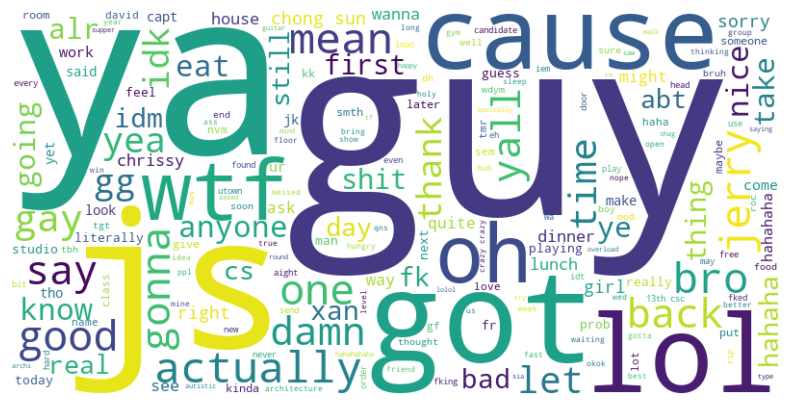

From my observations, Jarod Yoong sent 667 messages in April!

Hi, my name is Jarod, and this is what I did in April!

Well, it looks like I didn't do much in April, but that's okay! 

Here's a summary of what I did in April:

* Played a lot of video games and spent time in my studio
* Had conversations about life, the universe, and everything with my friends
* Felt a mix of emotions, including excitement, confusion, and frustration
* Attempted to balance schoolwork with personal life
* Had disagreements, debates, and arguments with my friends
* Prayed for the best in my life and asked for guidance from the universe


In [35]:
name = "jarod "
output = get_doing(name, chat)
print(output)